# Model Experimentation: Hyperparameter Optimization
This notebook conducts experiments on hyperparameter optimization.

## Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import sys
sys.path.insert(0, '../utils')
import model_utils
import geoutils

import logging
import warnings
logging.getLogger().setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

SEED = 42

%load_ext autoreload
%autoreload 2

## File Location

In [2]:
version = '20200509'
data_dir = "../data/"
output_dir = "../outputs/"
input_file = data_dir + '{}_dataset.csv'.format(version)

images_dir = data_dir + 'images/'
indices_dir = data_dir + 'indices/'
pos_mask_dir = data_dir + 'pos_masks/'
neg_mask_dir = data_dir + 'neg_masks/'

## Load Dataset

In [3]:
%%time
data = pd.read_csv(input_file).reset_index(drop=True)
print('Data dimensions: {}'.format(data.shape))
data.head(3)

Data dimensions: (1029869, 69)
CPU times: user 14.4 s, sys: 907 ms, total: 15.3 s
Wall time: 15.1 s


,B1_2015-2016,B2_2015-2016,B3_2015-2016,B4_2015-2016,B5_2015-2016,B6_2015-2016,B7_2015-2016,B8_2015-2016,B9_2015-2016,B10_2015-2016,...,mndwi_2019-2020,ui_2019-2020,nbi_2019-2020,brba_2019-2020,nbai_2019-2020,mbi_2019-2020,baei_2019-2020,target,uid,area
0,0.15100,0.13225,0.14240,0.16430,0.1899,0.25700,0.2960,0.25510,0.32295,0.0396,...,-0.438625,0.151655,0.209614,0.479385,-0.665204,-0.060444,0.948025,3,39,0
1,0.15100,0.12885,0.13790,0.16185,0.1899,0.25700,0.2960,0.25755,0.32295,0.0396,...,-0.435450,0.151655,0.213526,0.488330,-0.663010,-0.059064,0.952352,3,39,0
2,0.15895,0.13730,0.15185,0.18915,0.2264,0.28555,0.3268,0.28085,0.35740,0.0416,...,-0.447333,0.145385,0.222971,0.473118,-0.661291,-0.060496,0.911748,3,39,0


## Resample Dataset

In [4]:
data = model_utils.resample(data, num_neg_samples=30000, random_state=SEED)
print('Data dimensions: {}'.format(data.shape))
data.head(3)

Data dimensions: (293756, 69)


,B1_2015-2016,B2_2015-2016,B3_2015-2016,B4_2015-2016,B5_2015-2016,B6_2015-2016,B7_2015-2016,B8_2015-2016,B9_2015-2016,B10_2015-2016,...,mndwi_2019-2020,ui_2019-2020,nbi_2019-2020,brba_2019-2020,nbai_2019-2020,mbi_2019-2020,baei_2019-2020,target,uid,area
0,0.1748,0.12640,0.12590,0.12075,0.1288,0.2291,0.28325,0.2551,0.31165,0.03960,...,-0.325365,0.336843,0.097095,0.493299,-0.683798,-0.120547,1.149291,2,62,0
1,0.2093,0.19810,0.20230,0.21700,0.2178,0.2767,0.32240,0.3020,0.34780,0.03530,...,-0.212563,0.098564,0.242471,0.716410,-0.623340,-0.022285,1.042249,2,64,0
2,0.2062,0.20505,0.21575,0.23320,0.2083,0.2836,0.33810,0.3109,0.37400,0.03575,...,-0.235786,0.266124,0.158668,0.655587,-0.632521,-0.078219,1.101300,2,60,0


## Machine Learning Pipeline

In [5]:
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
SEED = 42

## Define Features and Target Label

In [6]:
label = 'target'
features = [column  for column in data.columns[:-3]]
data[label] = data[label].replace({2:0, 3:0})

grids = data['uid']
splits = data[['area']]
X = data[features]
y = data[label]

print('Data dimensions: {}'.format(data.shape))
print('Class distribution:\n{}'.format(data['target'].value_counts()))

X.head(3)

Data dimensions: (293756, 69)
Class distribution:
0    270000
1     23756
Name: target, dtype: int64


,B1_2015-2016,B2_2015-2016,B3_2015-2016,B4_2015-2016,B5_2015-2016,B6_2015-2016,B7_2015-2016,B8_2015-2016,B9_2015-2016,B10_2015-2016,...,ndvi_2019-2020,ndbi_2019-2020,savi_2019-2020,mndwi_2019-2020,ui_2019-2020,nbi_2019-2020,brba_2019-2020,nbai_2019-2020,mbi_2019-2020,baei_2019-2020
0,0.1748,0.12640,0.12590,0.12075,0.1288,0.2291,0.28325,0.2551,0.31165,0.03960,...,0.361130,-0.102406,0.290864,-0.325365,0.336843,0.097095,0.493299,-0.683798,-0.120547,1.149291
1,0.2093,0.19810,0.20230,0.21700,0.2178,0.2767,0.32240,0.3020,0.34780,0.03530,...,0.033153,0.061558,0.076850,-0.212563,0.098564,0.242471,0.716410,-0.623340,-0.022285,1.042249
2,0.2062,0.20505,0.21575,0.23320,0.2083,0.2836,0.33810,0.3109,0.37400,0.03575,...,0.154722,-0.047662,0.183498,-0.235786,0.266124,0.158668,0.655587,-0.632521,-0.078219,1.101300


## Logistic Regression

100%|██████████| 9/9 [33:34<00:00, 223.78s/it]


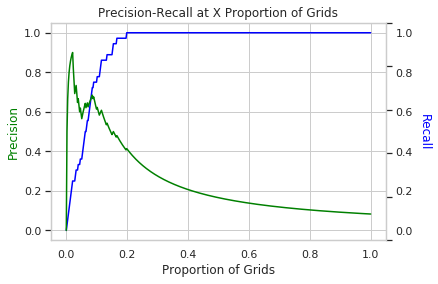

CPU times: user 7min 3s, sys: 5.56 s, total: 7min 8s
Wall time: 33min 36s


In [19]:
%%time
lr =  LogisticRegression()
param_grid = {'classifier__C': [0.001, 0.1, 0.5, 1, 5, 10, 100, 1000]}
lr_results = model_utils.nested_spatial_cv(
    lr, X, y, splits=splits, grids=grids, param_grid=param_grid, verbose=2
)
lr_results_grid = model_utils.get_grid_level_results(lr_results)

# Save results
lr_results.to_csv(output_dir+'{}_logistic_regression.csv'.format(version), index=False)
lr_results_grid.to_csv(output_dir+'{}_logistic_regression_grids.csv'.format(version), index=False);

## LinearSVC

In [ ]:
%%time
lsvc = LinearSVC(random_state=SEED)
param_grid = {'classifier__C': [0.001, 0.1, 0.5, 1, 5, 10, 100, 1000]}
lsvc_results = model_utils.nested_spatial_cv(
    lsvc, X, y, splits=splits, grids=grids, param_grid=param_grid, verbose=2
)
lsvc_results_grid = model_utils.get_grid_level_results(lsvc_results)

# Save results
lsvc_results.to_csv(output_dir+'{}_linear_svm.csv'.format(version), index=False)
lsvc_results_grid.to_csv(output_dir+'{}_linear_svm_grids.csv'.format(version), index=False);

## Naive Bayes

100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


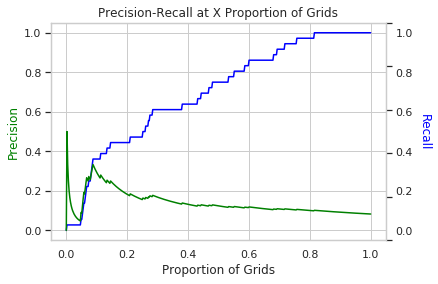

CPU times: user 13.1 s, sys: 1.03 s, total: 14.1 s
Wall time: 8.02 s


In [7]:
%%time
gnb = GaussianNB()
gnb_results = model_utils.nested_spatial_cv(
    gnb, X, y, splits=splits, grids=grids, param_grid=None, search_type=None, feature_selection=None, verbose=2
)
gnb_results_grid = model_utils.get_grid_level_results(gnb_results)

# Save results
gnb_results.to_csv(output_dir+'{}_naive_bayes.csv'.format(version), index=False)
gnb_results_grid.to_csv(output_dir+'{}_naive_bayes_grids.csv'.format(version), index=False);

## Ridge Classifier

100%|██████████| 9/9 [03:21<00:00, 22.38s/it]


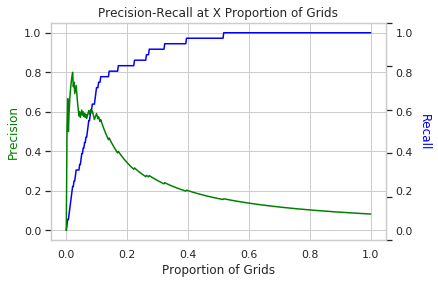

CPU times: user 29.3 s, sys: 4.32 s, total: 33.6 s
Wall time: 3min 23s


In [8]:
%%time
rc =  RidgeClassifier()
param_grid = {'classifier__alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
rc_results = model_utils.nested_spatial_cv(rc, X, y, splits=splits, grids=grids, param_grid=param_grid, verbose=2)
rc_results_grid = model_utils.get_grid_level_results(rc_results)

# Save results
rc_results.to_csv(output_dir+'{}_ridge_classifier.csv'.format(version), index=False)
rc_results_grid.to_csv(output_dir+'{}_ridge_classifier_grids.csv'.format(version), index=False);

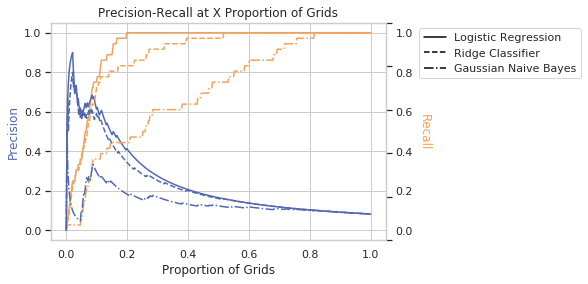

In [33]:
classifiers = ['Logistic Regression', 'Ridge Classifier', 'Gaussian Naive Bayes']
results_list = [lr_results_grid, rc_results_grid, gnb_results_grid]
model_utils.plot_precision_recall(results_list, classifiers=classifiers)

## Random Forest

In [ ]:
%%time
param_grid = {
    'classifier__n_estimators': [int(x) for x in np.linspace(start=10, stop=500, num=10)],
    'classifier__max_features': ['auto', 'sqrt'],
    'classifier__max_depth': [5, 6, 7, 8, 9, 10],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}
rf = RandomForestClassifier(random_state=SEED)
rf_results = model_utils.nested_spatial_cv(
    rf, X, y, splits=splits, param_grid=param_grid, search_type='random', verbose=2
);

## Gradient Boosted Trees

In [ ]:
%%time
param_grid = {
    'classifier__loss': ['deviance', 'exponential'],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.25, 0.5, 1.0],
    'classifier__n_estimators': [int(x) for x in np.linspace(start=10, stop=500, num=10)],
    'classifier__max_features': ['auto', 'sqrt'],
    'classifier__max_depth': [5, 6, 7, 8, 9, 10],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
}
gbc = GradientBoostingClassifier(random_state=SEED)
gbc_results = model_utils.nested_spatial_cv(
    gbc, X, y, splits=splits, param_grid=param_grid, search_type='random', verbose=2
);